In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Model

In [2]:
from AR2UNet import AttentionR2UNet

#### Dataloader

In [3]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_mask_pairs = self.get_image_mask_pairs()

    def get_image_mask_pairs(self):
        image_mask_pairs = []
        for patient_folder in os.listdir(self.root_dir):
            patient_dir = os.path.join(self.root_dir, patient_folder)
            if os.path.isdir(patient_dir):
                for file in os.listdir(patient_dir):
                    if not file.endswith("_mask.tif"):
                        image_path = os.path.join(patient_dir, file)
                        mask_path = os.path.join(patient_dir, file.replace(".tif", "_mask.tif"))
                        image_mask_pairs.append((image_path, mask_path))
        return image_mask_pairs

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        image = Image.open(img_path).convert("RGB")  # Load the .tif image
        mask = Image.open(mask_path).convert("L")    # Load the .tif mask

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


In [4]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [5]:
from torch.utils.data import DataLoader, random_split

root_dir="drive/MyDrive/Computer Vision/Semantic Segmentation/Brain Tumor Segmentation/"


dataset = SegmentationDataset(root_dir=root_dir,
                              transform=image_transform,
                              target_transform=mask_transform)


In [6]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [7]:
import torch.optim as optim
import torch.nn as nn
import torch


model = AttentionR2UNet(input_channels=3, num_classes = 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
model = AttentionR2UNet(input_channels=3, num_classes=1)

model.load_state_dict(torch.load('drive/MyDrive/Computer Vision/Semantic Segmentation/Brain_Tumor_model.pth'))

model = model.to(device)

<ipython-input-8-0721e2567290>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('drive/MyDrive/Computer Vision/Semantic Segmentation/Brain_T

#### Training

In [9]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.0048
Epoch [2/10], Loss: 0.0048
Epoch [3/10], Loss: 0.0048
Epoch [4/10], Loss: 0.0048
Epoch [5/10], Loss: 0.0048
Epoch [6/10], Loss: 0.0048
Epoch [7/10], Loss: 0.0048
Epoch [8/10], Loss: 0.0048
Epoch [9/10], Loss: 0.0048
Epoch [10/10], Loss: 0.0048


In [13]:
torch.save(model.state_dict(), 'drive/MyDrive/Computer Vision/Semantic Segmentation/Brain_Tumor_model.pth')

#### Evaluation

In [10]:
import torch
import numpy as np

def compute_metrics(outputs, targets, num_classes=1):
    smooth = 1e-6  # small constant to avoid division by zero

    # Apply a threshold to get binary predictions
    preds = torch.sigmoid(outputs) > 0.5
    preds = preds.float()

    # Flatten the tensors
    preds = preds.view(-1)
    targets = targets.view(-1)

    # Compute True Positives (TP), False Positives (FP), False Negatives (FN)
    TP = (preds * targets).sum().float()
    FP = ((preds == 1) * (targets == 0)).sum().float()
    FN = ((preds == 0) * (targets == 1)).sum().float()

    # 1. IoU (Intersection over Union)
    iou = (TP + smooth) / (TP + FP + FN + smooth)

    # 2. Dice Coefficient (F1 Score)
    dice = (2 * TP + smooth) / (2 * TP + FP + FN + smooth)

    # 3. Pixel Accuracy
    pixel_accuracy = (preds == targets).sum().float() / len(preds)

    # 4. Mean Pixel Accuracy (MPA)
    class_accuracies = []
    for c in range(num_classes):
        class_preds = (preds == c)
        class_targets = (targets == c)
        class_acc = (class_preds == class_targets).sum().float() / class_targets.sum().float()
        class_accuracies.append(class_acc)
    mean_pixel_accuracy = torch.mean(torch.stack(class_accuracies))

    # 5. Precision and Recall
    precision = (TP + smooth) / (TP + FP + smooth)
    recall = (TP + smooth) / (TP + FN + smooth)

    return {
        "IoU": iou.item(),
        "Dice": dice.item(),
        "Pixel Accuracy": pixel_accuracy.item(),
        "Mean Pixel Accuracy": mean_pixel_accuracy.item(),
        "Precision": precision.item(),
        "Recall": recall.item(),
    }

model.eval()
with torch.no_grad():
    metrics = {
        "IoU": [],
        "Dice": [],
        "Pixel Accuracy": [],
        "Mean Pixel Accuracy": [],
        "Precision": [],
        "Recall": [],
    }

    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # Compute metrics
        batch_metrics = compute_metrics(outputs, masks, num_classes=2)

        # Store metrics for the current batch
        for key, value in batch_metrics.items():
            metrics[key].append(value)

    # Average over all batches
    final_metrics = {key: np.mean(values) for key, values in metrics.items()}

print("Final Metrics:", final_metrics)

Final Metrics: {'IoU': 0.3732105041352828, 'Dice': 0.5129431238828023, 'Pixel Accuracy': 0.993312931060791, 'Mean Pixel Accuracy': inf, 'Precision': 0.7039208872424877, 'Recall': 0.43738189064568317}


In [9]:
for i, (images, masks) in enumerate(val_loader):
    if i == 4:
        break

images = images.to(device)
masks = masks.to(device)
outputs = model(images)

#### Visualization

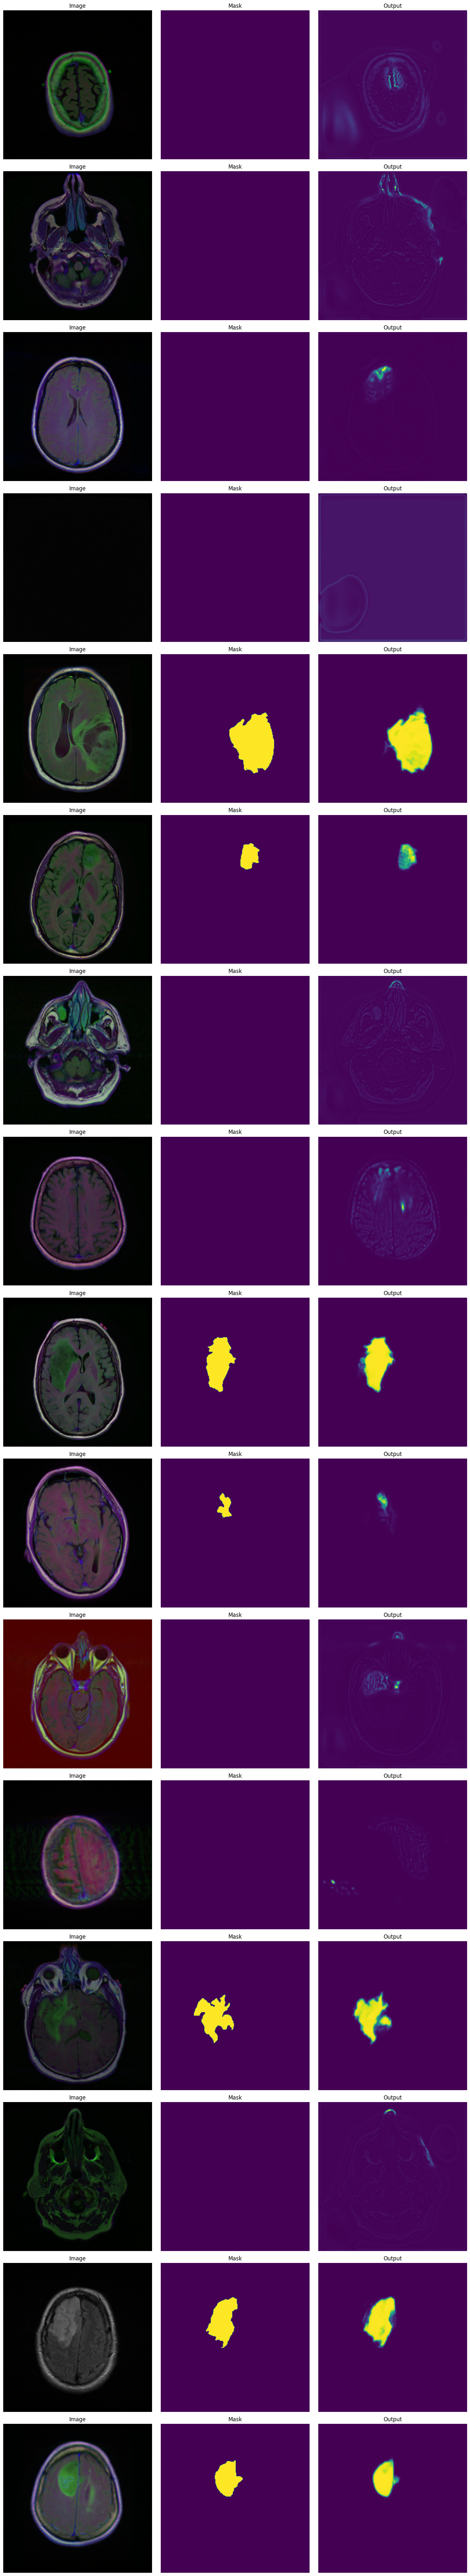

In [18]:

import matplotlib.pyplot as plt

def plot_comparison(images, masks, outputs, num_images=5):
  fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(15, 5 * num_images))

  for i in range(num_images):
      # Move tensors to CPU and convert to NumPy arrays
      image = images[i].cpu().numpy().transpose((1, 2, 0))
      mask = masks[i].cpu().numpy().squeeze()
      output = torch.sigmoid(outputs[i]).cpu().detach().numpy().squeeze()

      # Display the image, mask, and output
      axes[i, 0].imshow(image)
      axes[i, 0].set_title("Image")
      axes[i, 0].axis("off")

      axes[i, 1].imshow(mask)
      axes[i, 1].set_title("Mask")
      axes[i, 1].axis("off")

      axes[i, 2].imshow(output)
      axes[i, 2].set_title("Output")
      axes[i, 2].axis("off")

  plt.tight_layout()
  plt.show()


plot_comparison(images, masks, outputs, num_images=16)